## Importing Library

In [1]:
import os
from tqdm.notebook import tqdm_notebook as tqdm
import cv2
import numpy as np
import pandas as pd
from glob import glob
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.utils import np_utils
import tensorflow as tf
import keras
from keras.applications.mobilenet import MobileNet, preprocess_input

from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


## Defining Class

In [2]:
CLASS = {
    'Black-grass': 0,
    'Charlock': 1,
    'Cleavers': 2,
    'Common Chickweed': 3,
    'Common wheat': 4,
    'Fat Hen': 5,
    'Loose Silky-bent': 6,
    'Maize': 7,
    'Scentless Mayweed': 8,
    'Shepherds Purse': 9,
    'Small-flowered Cranesbill': 10,
    'Sugar beet': 11
}

INV_CLASS = {CLASS[j]:j for j in CLASS}

In [3]:
def preprop_img(image_path, verbose=0):
    if verbose:
        print(image_path)
    img=cv2.imread(image_path)
    img=cv2.resize(img, (128,128))
    return img

## EDA, Visualization and Data preparation

In [4]:
#Reading the image file and converting them to array
train_image=[]
train_label=[]
BASE='../input/plant-seedlings-classification/train'
for i in tqdm(os.listdir(BASE), total=len(CLASS)):
    for j in os.listdir(os.path.join(BASE,i)):
        train_image.append(preprop_img(os.path.join(BASE,i,j)))
        train_label.append(CLASS[i])
train_image=np.array(train_image)
train_label=np.array(train_label)

print("Shape of train_image:",train_image.shape,"Shape of train_label:",train_label.shape)


Shape of train_image: (4750, 128, 128, 3) Shape of train_label: (4750,)


In [5]:
train_label_cat = keras.utils.to_categorical(train_label,len(CLASS))
print(train_label_cat.shape)

(4750, 12)


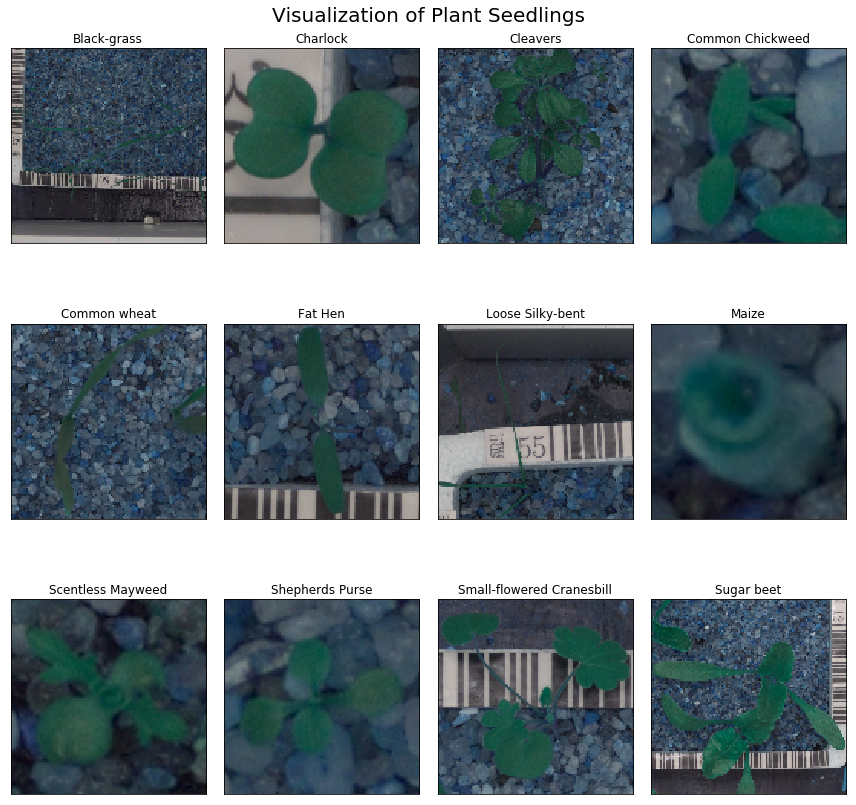

In [6]:
plt.figure(figsize=(12,12))

for i in range(12):  
    
    plt.subplot(3,4,i+1)
    
    index = np.where(train_label==i)[0][1]
    plt.imshow(train_image[index])
    plt.title(INV_CLASS[np.argmax(train_label_cat[index])])
    plt.xticks([]), plt.yticks([])

plt.suptitle("Visualization of Plant Seedlings", fontsize=20)    
plt.tight_layout()
plt.show()

#### Cleaning Image data
We will clean the image by removing the image background. This help us in following ways;
* Since we have less training data, it reduces our need for more training data.
* Reduces false positives and hence improve accuracy.
* Here in our given image dataset, it is important to do background subtraction because in most images the plants are small and for training the data with smaller objects in it is harder and it will be difficult for the model to pick them up.

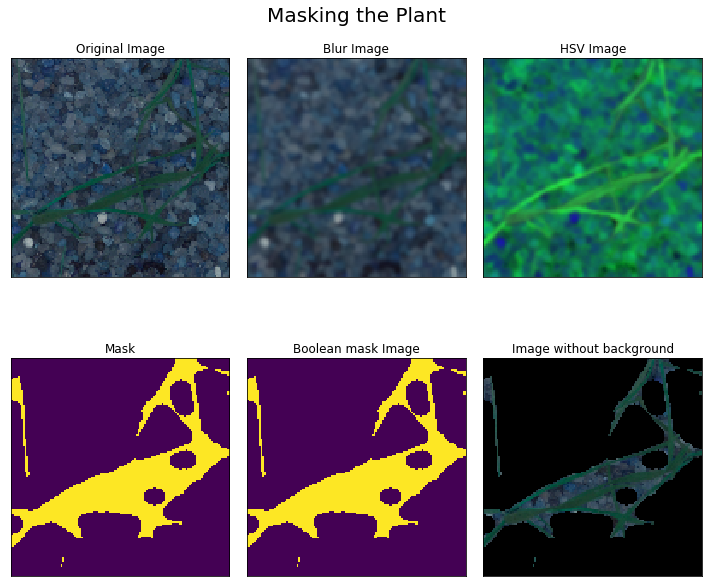

In [7]:
clearTrainImg = []
examples = []; getEx = True
plt.figure(figsize=(10,9))

for img in train_image:
    
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.xticks([]), plt.yticks([]), plt.title("Original Image")
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.xticks([]), plt.yticks([]), plt.title("Blur Image")
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.xticks([]), plt.yticks([]), plt.title("HSV Image")
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.xticks([]), plt.yticks([]), plt.title("Mask")
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.xticks([]), plt.yticks([]), plt.title("Boolean mask Image")
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        plt.xticks([]), plt.yticks([]), plt.title("Image without background")
        getEx = False

plt.suptitle("Masking the Plant", fontsize=20)
plt.tight_layout()

Here we have created the HSV image. And after that we'll create mask based on empirically selected range of green color, convert it to boolean mask and apply it to the origin image.

* Use gaussian blur for remove noise
* Convert color to HSV
* Create mask
* Create boolean mask
* Apply boolean mask and getting image whithout background

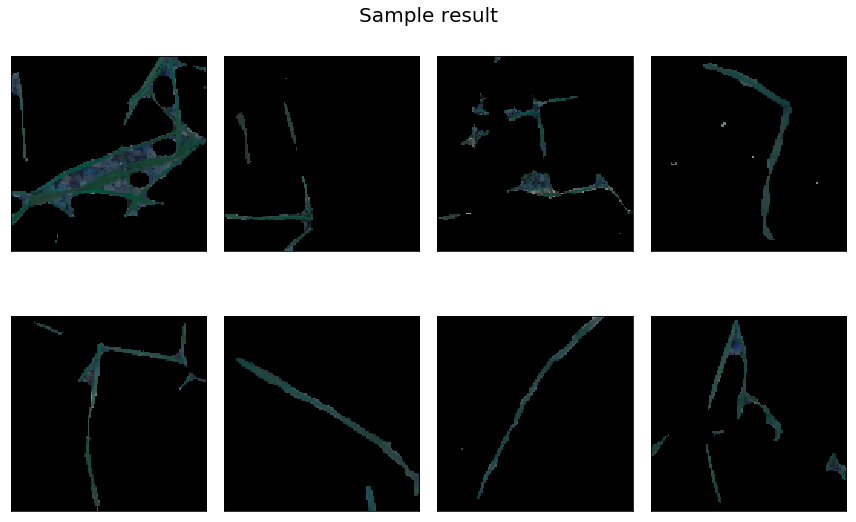

In [8]:
# Visulaising the sample result
clearTrainImg = np.asarray(clearTrainImg)
plt.figure(figsize=(12,8))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i])
    plt.xticks([]), plt.yticks([])
    
plt.suptitle("Sample result", fontsize=20)  
plt.tight_layout()
plt.show()

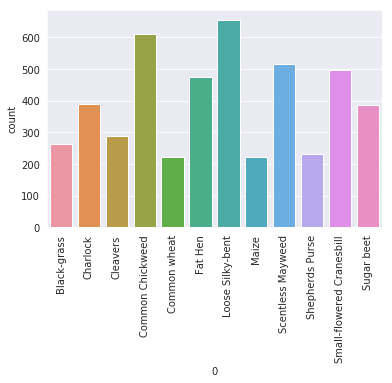

In [9]:
# Plot of label types numbers
classes = list(INV_CLASS.values())

sns.set_style('darkgrid')  
ax = sns.countplot(x=0, data=pd.DataFrame(train_label))
ax.set_xticklabels(classes)

plt.xticks(rotation=90)
plt.show()

## Normalising Input
* Now set the values of input from [0...255] to [0...1] (RGB color-space encode colors with numbers [0...255]). CNN will be faster train if we use [0...1] input

In [10]:
clearTrainImg = clearTrainImg / 255

## Splitting the data
* Splitting the image data into train and test class

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(clearTrainImg,train_label_cat, shuffle=True, test_size=0.2)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(3800, 128, 128, 3) (3800, 12)
(950, 128, 128, 3) (950, 12)


In [12]:
X_train=X_train.astype('float32') 
X_test=X_test.astype('float32')

## Data Augmentation
* In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. This will help us in increasing the number of data in our dataset.
* This will change the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

In [13]:
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(X_train)

For the data augmentation, I choosed to :

* Randomly rotate some training images by 180 degrees.
* Randomly Zoom by 10% on training images.
* Randomly shift images horizontally by 10% of the width.
* Randomly shift images vertically by 10% of the height.
* Randomly flipped the image vertically and horizontally.

Once our model is ready, we will use this to train  the training dataset

## Model Building
* 1st trained data on model built from screatch.
* 2nd trained data on model built from transfer learning. (Used mobilenet)

In [14]:
#Got 90 % test accuracy on model built from scratch

tf.keras.backend.clear_session() #clear the weights

np.random.seed(2)  # Fix seed

model = Sequential([Conv2D(filters=64, kernel_size=(5, 5), input_shape=(128, 128, 3), activation='relu'),
                    BatchNormalization(axis=3),
                    Conv2D(filters=64, kernel_size=(5, 5), activation='relu'),
                    MaxPooling2D((2, 2)),
                    BatchNormalization(axis=3),
                    Dropout(0.1),
                    
                    Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
                    BatchNormalization(axis=3),
                    Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
                    MaxPooling2D((2, 2)),
                    BatchNormalization(axis=3),
                    Dropout(0.1),
                   
                    Conv2D(filters=256, kernel_size=(5, 5), activation='relu'),
                    BatchNormalization(axis=3),
                    Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
                    MaxPooling2D((2, 2)),
                    BatchNormalization(axis=3),
                    Dropout(0.1),
                   
                    Flatten(),
                    
                    Dense(256, activation='relu'),
                    BatchNormalization(),
                    Dropout(0.5),
                   
                    Dense(256, activation='relu'),
                    BatchNormalization(),
                    Dropout(0.5),
                   
                    Dense(12, activation='softmax')])



model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 64)      4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 64)      102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)      

In [15]:
# ALPHA = 1.0

# # mnet = MobileNet(input_shape=(128,128,3), include_top=False, alpha=ALPHA)

In [16]:
# # Got 91.26% accuracy on validation dataset on 10 epochs and with batch size as 32.
# tf.keras.backend.clear_session()

# for layers in mnet.layers:
#       layers.trainable = False

# model = Sequential([mnet,
#                     Flatten(),
                    
#                     Dense(256, activation='relu'),
#                     BatchNormalization(),
#                     Dropout(0.5),
                   
#                     Dense(256, activation='relu'),
#                     BatchNormalization(),
#                     Dropout(0.5),
                    
#                     Dense(12,activation='softmax')])

# model.summary()

# # compile model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])            

## Callback

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

In [18]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),epochs=5,
                    validation_data=(X_test, Y_test),
                    steps_per_epoch=(X_train.shape[0]),
                    verbose=1,
                    callbacks=[learning_rate_reduction])

Epoch 1/5
3800/3800 [==============================] - 605s 159ms/step - loss: 0.7120 - accuracy: 0.7644 - val_loss: 0.7461 - val_accuracy: 0.7453
Epoch 2/5
3800/3800 [==============================] - 598s 157ms/step - loss: 0.2846 - accuracy: 0.8976 - val_loss: 0.2291 - val_accuracy: 0.9242
Epoch 3/5
3800/3800 [==============================] - 597s 157ms/step - loss: 0.2060 - accuracy: 0.9253 - val_loss: 0.2776 - val_accuracy: 0.8916
Epoch 4/5
1976/3800 [==============>...............] - ETA: 4:44 - loss: 0.1677 - accuracy: 0.9392

## Visualizing the training

<Figure size 1440x720 with 0 Axes>

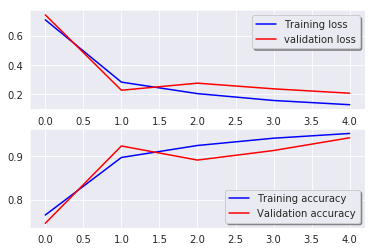

In [19]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Preparing Test Data

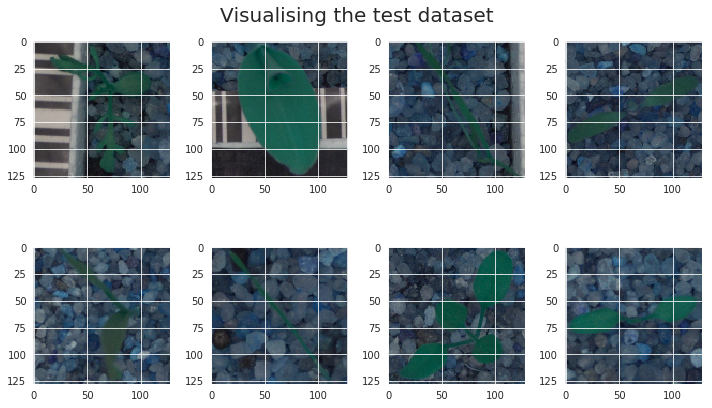

In [20]:
path = '../input/plant-seedlings-classification/test/*.png'
files = glob(path)

testImg = []

for img in files:
    testImg.append(cv2.resize(cv2.imread(img), (128, 128)))

testImg = np.asarray(testImg)  # Train images set

plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(testImg[i])
    
plt.suptitle("Visualising the test dataset", fontsize=20)    
plt.tight_layout()
plt.show()

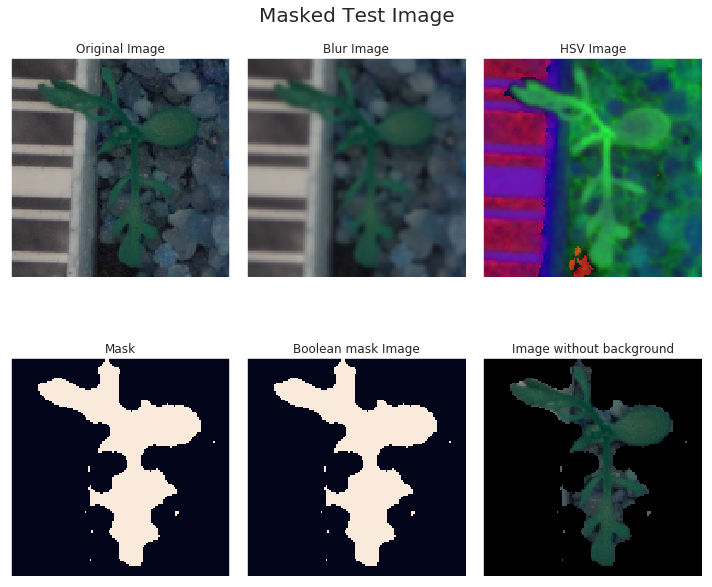

In [21]:
clearTestImg = []
examples = []; getEx = True
plt.figure(figsize=(10,9))

for img in testImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTestImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.xticks([]), plt.yticks([]), plt.title("Original Image")
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.xticks([]), plt.yticks([]), plt.title("Blur Image")
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.xticks([]), plt.yticks([]), plt.title("HSV Image")
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.xticks([]), plt.yticks([]), plt.title("Mask")
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.xticks([]), plt.yticks([]), plt.title("Boolean mask Image")
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        plt.xticks([]), plt.yticks([]), plt.title("Image without background")
        getEx = False

plt.suptitle("Masked Test Image", fontsize=20)
plt.tight_layout()
clearTestImg = np.asarray(clearTestImg)

In [22]:
#Normalizing the test data
clearTestImg = clearTestImg / 255

## Predictions

In [23]:
pred = model.predict(clearTestImg)
predNum = np.argmax(pred, axis=1)

In [24]:
testId = []
for i in files:
    testId.append(i.split('/')[-1]) 

In [25]:
predStr=[]
for i in predNum:
    predStr.append(INV_CLASS[i])

In [26]:
# # Write result to file
# PS = {'file': testId, 'species': predStr}
# PS = pd.DataFrame(res)
# PS.to_csv("PS.csv", index=False)

## Visualising Prediction

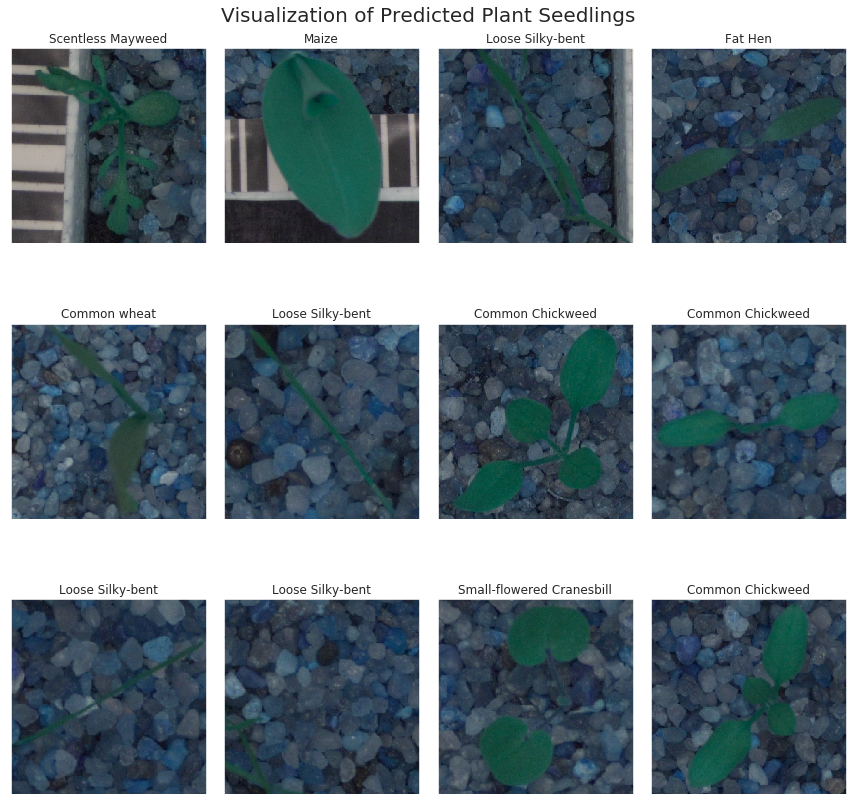

In [27]:
plt.figure(figsize=(12,12))

for i,j in enumerate(files[:12]):  
    
    plt.subplot(3,4,i+1)
    
    img = np.array(cv2.imread(j))
    plt.imshow(img)
    plt.title(predStr[i])
    plt.xticks([]), plt.yticks([])

plt.suptitle("Visualization of Predicted Plant Seedlings", fontsize=20)    
plt.tight_layout()
plt.show()